### Import libraries

In [1]:
import sys
sys.path.append("..")
from model import experimental_model, experimental2d_model, grapher
from data import batch_creator, loader, data_generation
from helpers import helpers, plotter, metrics, masks
from keras.callbacks import ModelCheckpoint
from inference import infer
import tensorflow as tf; import keras
import time

Using TensorFlow backend.


In [2]:
# options: rbf, periodic
print('Kernel? rbf/rbf_noise/periodic/rbf_2D')
kernel = input()
print('How many observations? (deafult 150000)')
dataset_size = input()
print('Do you want to overwrite data? True/False')
rewrite = input()
print('Multiple dim? 0/1')
d = bool(int(input()))
save_dir = '/Users/omernivron/Downloads/GPT_' + kernel

Kernel? rbf/rbf_noise/periodic/rbf_2D
rbf_2D
How many observations? (deafult 150000)
1
Do you want to overwrite data? True/False
False
Multiple dim? 0/1
1


In [3]:
data = loader.load_data(kernel, size = dataset_size, rewrite = rewrite.capitalize(), diff_x= True, noise = True, d = True)

['em_te_2.npy', 'pad_pos_tr.npy', 'pad_pos_te.npy', 'em_te.npy', 'em_tr.npy', 'pad_y_fren_tr.npy', 'pad_y_fren_te.npy', 'em_tr_2.npy']


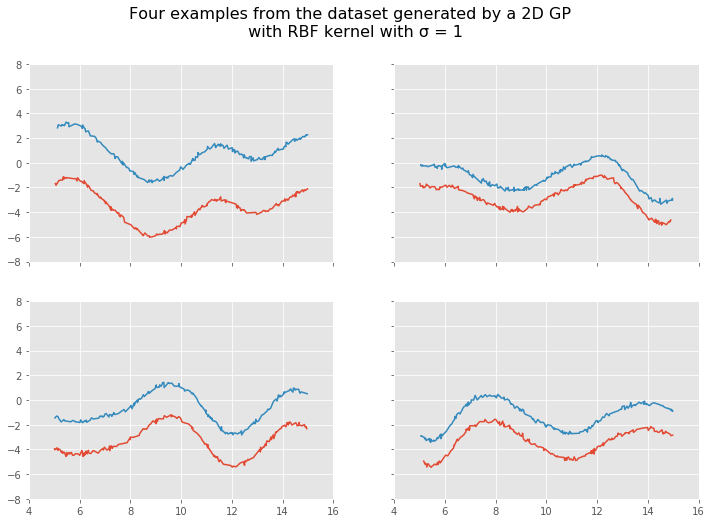

In [4]:
if d:
    plotter.plot_2d_examples(data[1], data[-3], data[-1])
else:
    plotter.plot_examples(data[0], data[4])

In [33]:
train_step, test_step, loss_object, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [34]:
# batch_pos_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_pos_tr, pad_y_fren_tr, batch_s=1)

Already exists
Restored from /Users/omernivron/Downloads/GPT_rbf_2D/ckpt/check_run_1/ckpt-4
Tensor("decoder_3/multi_head_attention2d_3/strided_slice:0", shape=(), dtype=int32)
Tensor("decoder_3/multi_head_attention2d_3/strided_slice:0", shape=(), dtype=int32)
Tensor("decoder_3/multi_head_attention2d_3/strided_slice:0", shape=(), dtype=int32)


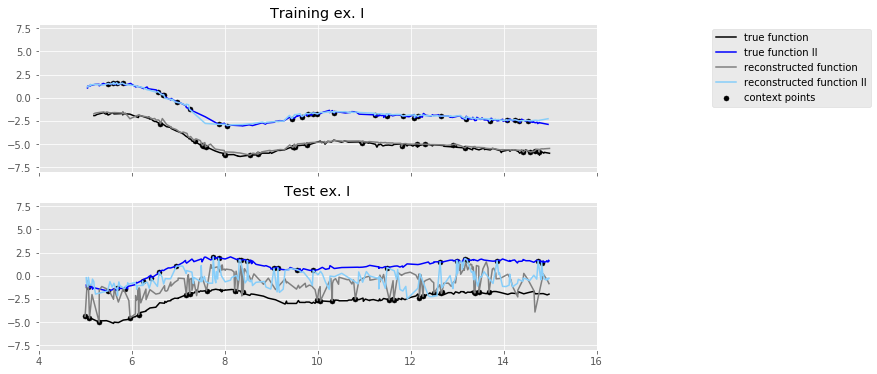

Epoch 0 batch 0 train Loss -0.4054 test Loss 20.2130 with training MSE metric 0.0361 and testing MSE metric 2.7860
learning rate is 0.0003000000142492354


IndexError: index 348 is out of bounds for axis 0 with size 348

In [35]:
if __name__ == '__main__':
    EPOCHS = 75; batch_s  = 64; run = 1; step = 0; train_steps = 35000; heads = 32; ℯ = 512; context = 50
    l = [256, 256, 64, 32]
    name_comp = 'run_' + str(run) 
    logdir = save_dir + '/logs/' + name_comp
    writer = tf.summary.create_file_writer(logdir)
    folder = save_dir + '/ckpt/check_' + name_comp; 
#     lr_fn = tf.optimizers.schedules.PolynomialDecay(9e-3, train_steps, 1e-7, 2)
    optimizer_c = tf.keras.optimizers.Adam(3e-4)
    ℯ, l1, _, l2, l3 = helpers.load_spec(folder, ℯ, l, d = d); 
    helpers.mkdir(folder)
    if d:
        decoder = experimental2d_model.Decoder(ℯ, l1, l2, l3, num_heads = heads)
    else:
        decoder = experimental_model.Decoder(ℯ, l1, l2, l3, num_heads = heads); 
    tf.random.set_seed(443)  
    num_batches = int(data[5].shape[0] / batch_s) if d else int(data[4].shape[0] / batch_s)
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
#     optimizer_c = tf.keras.optimizers.Adam(3e-4)
    with writer.as_default():
        for epoch in range(EPOCHS):

            start = time.time()

            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                if d:
                    b_data = batch_creator.create_batch_gp_mim_2(em_pos = data[-4], pos = data[1], tar = data[-3], batch_s=64, d = True, em_2 = data[-1])
                    pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, b_data[2], b_data[0], d = True,  pos2 = b_data[3])
                else:
                    b_data = batch_creator.create_batch_gp_mim_2(em_pos = data[3], pos = data[0], tar = data[4], batch_s=64)
                    pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, pos = b_data[2], tar = b_data[0], context_p = context)


                if ((epoch == 0) & (batch_n == 0)): helpers.write_speci(folder, names, shapes)
                if batch_n % 300 == 0:
                    m_te.reset_states(); test_loss.reset_states()
                    if d:
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, pos_te = data[3][:500, :], tar_te = data[5][:500, :], d = True, pos2_te = data[0][:500, :])
                        plotter.follow_training_plot2d(x_tr = b_data[1], y_tr = b_data[0], em_2_tr = b_data[3] , pred = pred, x_te = data[2][:500], y_te = data[-2][:500], em_2_te = data[0][:500] ,pred_te = pred_te, num_context = context)
                    else:
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, pos_te = data[2][:500, :], tar_te = data[5][:500, :], context_p = context)
                        plotter.follow_training_plot(x_tr = b_data[1], y_tr = b_data[0], pred = pred, x_te = data[1][:500, :], y_te = data[5][:500, :], pred_te = pred_te, num_context = context)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    print('learning rate is {}'.format(optimizer_c._decayed_lr('float32').numpy()))
                    if d:
                        m0, m1 = metrics.r_sq_2d(b_data[0][:, 1:], pred.numpy(), b_data[3][:, 1:], context_p = context)
                        m0_te, m1_te = metrics.r_sq_2d(data[-2][:500], pred_te.numpy(), data[0][:500], context_p = context)
                        print('r squared training, series 0: {}, series 1: {}'.format(m0, m1))
                        print('r squared testing, series 0: {}, series 1: {}'.format(m0_te, m1_te))

                    else: 
                        print('r squared training: ', metrics.r_squared(m_tr.result(), b_data[0][:, (context + 1):]))
                        print('r squared testing: ', metrics.r_squared(m_te.result(), data[5][:500, (context + 1):], batch_s = 500))


                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [36]:
import numpy as np 

In [37]:
context_p = 50 

In [69]:
y = b_data[0][:, 1:]; pred_te1 = pred.numpy(); em_2_1 =  b_data[3][:, 1:]

In [70]:
n = y.shape[0]
r_sq0 = []
r_sq1 = []
for row in range(n):
    idx0 = np.where(em_2_1[row, (context_p):] == 0)[0]
    idx1 = np.where(em_2_1[row, (context_p):] == 1)[0]
    y_1 = y[row, (context_p):]
    pred_1 = pred_te1[row, (context_p):]
    mse_ratio0 = np.sum((y_1[idx0] - pred_1[idx0]) ** 2) / np.sum((y_1[idx0] - np.mean(y_1[idx0])) ** 2)
    mse_ratio1 = np.sum((y_1[idx1] - pred_1[idx1]) ** 2) / np.sum((y_1[idx1] - np.mean(y_1[idx1])) ** 2)
    r_sq0.append(1 - mse_ratio0)
    r_sq1.append(1 - mse_ratio1)

In [71]:
r_sq0

[0.9771137310626112,
 0.9590315166570598,
 0.9609659808873569,
 0.9694230626044263,
 0.98157870631592,
 0.9749037073004294,
 0.9661373139935685,
 0.9775359765527144,
 0.9751086286031163,
 0.9747829841757413,
 0.9820907883191413,
 0.9845020375724539,
 0.9761271353363795,
 0.9596928362063939,
 0.9825787323935623,
 0.973753581687775,
 0.980388836920881,
 0.9745426711496623,
 0.9745789997578571,
 0.9657398327989112,
 0.9768648547338922,
 0.9653539771736788,
 0.9802935991702613,
 0.986952647594996,
 0.9857332897033523,
 0.9759310768516953,
 0.9808122900318361,
 0.9755570686359493,
 0.9515898072536741,
 0.9694424343644287,
 0.9789859708599328,
 0.9735909713712242,
 0.9838701292839156,
 0.9778625478415158,
 0.9843132447624506,
 0.9857006771087277,
 0.9699734094820888,
 0.9827830171606612,
 0.9793814444454568,
 0.9772717823492653,
 0.9712935668169026,
 0.967251805916816,
 0.9770632361917833,
 0.9659576891597336,
 0.9843689792355546,
 0.9804712908651593,
 0.9681850703881448,
 0.9594382695426181

In [10]:
if d:
    idx = int(101)
    plotter.infer_plot2D(decoder,data[2][idx, :], data[6][idx, :], data[3][idx, :], data[0][idx, :], samples = 10)

else:  
    idx = int(101)
    plotter.infer_plot(decoder, em_te = data[2][idx, :], x_te = data[1][idx, :], y_te = data[-1][idx, :], num_steps = 150, samples = 10)